In [1]:
import sys, os, torch
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

if(torch.cuda.device_count() >= 1):
    device = "cuda:1"
else:
    device = 'cpu'

# move directory
os.chdir("..")

In [ ]:
import torch.nn as nn
from torchvision import transforms
from vision_transformer_pytorch import VisionTransformer

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
model.eval()

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import List, Literal

def get_attention_map(img, get_mask=False):
    x = transform(img)
    x.size()

    logits, att_mat = model(x.unsqueeze(0))

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return result

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)
    
def rollout(attentions : List[torch.Tensor], discard_ratio : float, head_fusion : Literal['mean', 'max', 'min']):
    # attentions : List which consist of [1, channels, height, width] size of attention data
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == 'mean':
                attention_heads_fused = attention.mean(axis = 1)
            elif head_fusion == 'max':
                attention_heads_fused = attention.max(axis = 1)[0]
            elif head_fusion == 'min':
                attention_heads_fused = attention.min(axis = 1)[0]
            
            flat = attention_heads_fused.view(attention_heads_fused.size()[0], -1)
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim = -1, largest = False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            
            I = torch.eye(attention_heads_fused.size(-1))
            
            print("attention_heads_fused : ", attention_heads_fused.size())
            print("I : ", I.size())
            a = (attention_heads_fused + 1.0 * I) / 2.0
            a = a / a.sum(dim = -1)
            
            result = torch.matmul(a, result)

    mask = result[0,0,1:]
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width)
    mask = mask.numpy()
    mask = mask / np.max(mask)
    return mask

In [3]:
from PIL import Image

img = Image.open("./dataset/dur21_dis0/test/disruption/21325_1369_1390/0000.jpg")

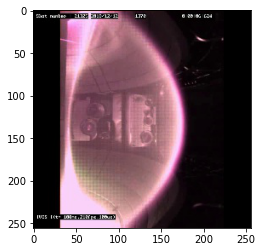

In [4]:
plt.imshow(img)

In [5]:
class VITAttentionRollout:
    def __init__(self, model : nn.Module, attention_layer_name = 'attn_drop', head_fusion = 'mean', discard_ratio = 0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        
        # for name, module in self.model.named_modules():
        #     for name_, module_ in module.named_children():
        #         if attention_layer_name in name_:
        #             module_.register_forward_hook(self.get_attention)
                    
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
        
        self.attentions = []
    
    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())
    
    def __call__(self, input_tensor : torch.Tensor):
        self.attentions = []
        
        with torch.no_grad():
            output = self.model(input_tensor)
        
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

x = transform(img).to(device).unsqueeze(0)
print("x : ", x.size())
model.to(device)

rollout_model = VITAttentionRollout(model)
att_mask = rollout_model(x)

x :  torch.Size([1, 3, 224, 224])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])


In [7]:
att_mask.shape

(14, 14)

In [8]:
rollout_model.attentions[-1].size()

torch.Size([1, 3, 197, 197])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


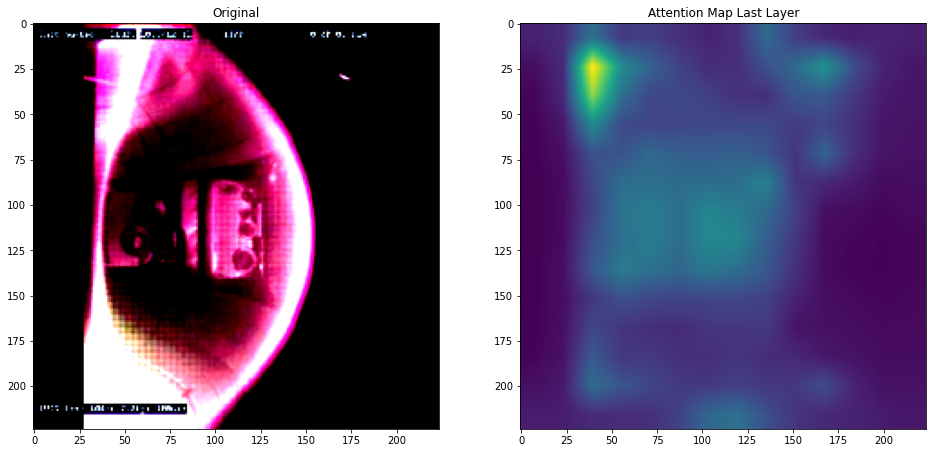

In [9]:
img = Image.open("./dataset/dur21_dis0/test/disruption/21325_1369_1390/0000.jpg")
img = transform(img).numpy()

def plot_attention_map(original_img, att_map):
    original_img = np.transpose(original_img, (1,2,0))
    att_map = cv2.resize(att_map, (224, 224))
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)

plot_attention_map(img, att_mask)

In [7]:
from src.models.ViViT import ViViT

model = ViViT(
    image_size = 128,
    patch_size = 16,
    n_classes = 2,
    n_frames = 21,
    dim = 128,
    depth = 2,
    n_heads = 4,
    pool = "mean",
    in_channels = 3,
    d_head = 64,
    dropout = 0.1,
    embedd_dropout=0.1,
    scale_dim = 8
)

save_best_dir = "./weights/ViViT_clip_21_dist_3_Focal_DRW_seed_40_best.pt"
model.load_state_dict(torch.load(save_best_dir, map_location=torch.device('cpu')))

for name, module in model.named_modules():
    for name_, module_ in module.named_children():
        if "to_out" in name_ and "space_transformer" in name:
            print("name : {}, name_ : {}".format(name, name_))

name : space_transformer.layers.0.0.fn, name_ : to_out
name : space_transformer.layers.1.0.fn, name_ : to_out


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List, Literal, Optional

def rollout(attentions : List[torch.Tensor], discard_ratio : float, head_fusion : Literal["mean", 'max', 'min']):
    result = torch.eye(attentions[0].size()[-1]).unsqueeze(0)
    result = result.repeat((21,1,1))
    
    with torch.no_grad():
        for attention in attentions:
            
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"
            
            # attention_heads_fused : (21, 1, 17, 17)
            flat = attention_heads_fused.view(attention_heads_fused.size()[0], -1)
            
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim = -1, largest = False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            
            I = torch.eye(attention.size(-1)).unsqueeze(0).repeat((21,1,1))
            a = (attention_heads_fused + 1.0 * I) / 2.0
            
            result = torch.bmm(a, result)
            
    mask = result[:,0,1:]
    width = int(mask.size()[-1] ** 0.5)
    
    mask = mask.reshape(result.size()[0], 1, width, width)
    mask_interp = np.zeros((result.size()[0], 1, 128, 128))
    
    for idx in range(result.size()[0]):
        mask_interp[idx] = F.interpolate(mask[idx].view(1,1,width,width), size = (128,128), mode='bilinear', align_corners=False).numpy()

    mask_final = mask_interp / np.max(mask_interp)
    mask_final = np.max(mask_final, axis = 0).reshape(128,128,1)
    return mask_final

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class ViViTAttentionRollout:
    def __init__(self, model : nn.Module, layer_name = '0.fn.to_qkv', head_fusion = 'mean', discard_ratio = 0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
    
        for name, module in model.named_modules():
            if layer_name in name and "space_transformer" in name:
                module.register_forward_hook(self.get_attention)
        
        self.attentions = []
    
    def get_attention(self, module:nn.Module, input:torch.Tensor, output:torch.Tensor):
        
        h = self.model.n_heads
        output = torch.chunk(output, 3, -1)
        q,k,v = map(lambda t : rearrange(t, 'b n (h d) -> b h n d', h = h), output)
        
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.model.d_head ** (-0.5)
        attn = torch.softmax(dots, dim = -1)
        self.attentions.append(attn.cpu())
        
        # self.attentions.append(output.cpu())
    
    def __call__(self, input_tensor : torch.Tensor):
        self.attentions = []
        
        with torch.no_grad():
            output = self.model(input_tensor)
        
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

import pandas as pd
from src.utils.utility import preparing_video_dataset
from src.dataset import DatasetForVideo
from torch.utils.data import DataLoader

root_dir = "./dataset/temp"
shot_train, shot_valid, shot_test = preparing_video_dataset(root_dir,test_shot = 21310)
df_disrupt = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv")
    
train_data = DatasetForVideo(shot_train, df_disrupt, augmentation = True, augmentation_args=None, crop_size = 128, seq_len = 21, dist = 1)
train_loader = DataLoader(train_data, batch_size = 1, sampler=None, num_workers = 8, pin_memory=False)

sample_data, sample_label = next(iter(train_loader))

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

ViViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1=16, p2=16)
    (1): Linear(in_features=768, out_features=128, bias=True)
  )
  (space_transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (fn): Attention(
            (to_qkv): Linear(in_features=128, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=128, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (1): PreNorm(
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=1024, bias=True)
              (1): GELU()
              (2): Dropout(p=0.1, inplace=False)
              (3): Linear(in_features=1024, out_features=128, bias=True)
              (4): Dropout(p=0.1, in

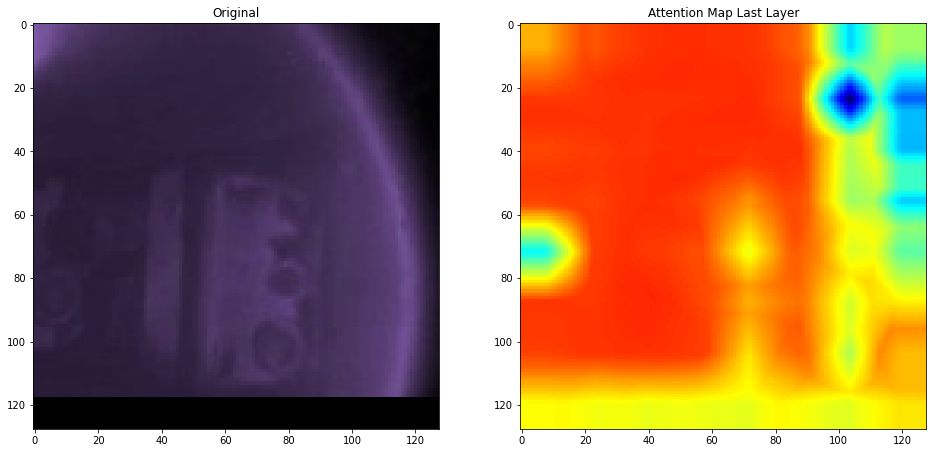

In [9]:
import cv2
import matplotlib.pyplot as plt

sample_data, sample_label = next(iter(train_loader))
sample_data = sample_data.to(device)

rollout_model = ViViTAttentionRollout(model)
att_mask = rollout_model(sample_data)

att_heatmap = cv2.applyColorMap(np.uint8(255 * att_mask), cv2.COLORMAP_JET)
att_result = att_heatmap / np.max(att_heatmap)
att_result = np.uint8(255 * att_result)

shot = sample_data.cpu().numpy()[0][:,-1,:,:]
shot = np.transpose(shot, (1,2,0))
shot += np.array([90, 98, 102])
shot = np.uint8(shot)

img = sample_data[:,:,-2,:,:].cpu().squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

att_map = cv2.resize(att_mask[-1], (128,128))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
ax1.set_title('Original')
ax2.set_title('Attention Map Last Layer')
_ = ax1.imshow(shot, cmap = plt.cm.get_cmap('jet'))
_ = ax2.imshow(att_result, cmap = plt.cm.get_cmap('jet'))

In [49]:
# what about temporal transformer

def rollout(attentions : List[torch.Tensor], discard_ratio : float, head_fusion : Literal["mean", 'max', 'min']):
    result = torch.eye(attentions[0].size()[-1]).unsqueeze(0)
    with torch.no_grad():
        for attention in attentions:
            
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"
            
            # attention_heads_fused : (1, 22, 22)
            flat = attention_heads_fused.view(attention_heads_fused.size()[0], -1)
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim = -1, largest = False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            
            I = torch.eye(attention.size(-1)).unsqueeze(0)
            a = (attention_heads_fused + 1.0 * I) / 2.0
            result = torch.bmm(a, result)
    
    mask = result[:,1:,1:].squeeze(0)
    mask = mask.numpy()
    mask = mask / np.max(mask)
    return mask

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class ViViTAttentionRollout:
    def __init__(self, model : nn.Module, layer_name = '0.fn.to_qkv', head_fusion = 'mean', discard_ratio = 0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
    
        for name, module in model.named_modules():
            if layer_name in name and "temporal_transformer" in name:
                module.register_forward_hook(self.get_attention)
        
        self.attentions = []
    
    def get_attention(self, module:nn.Module, input:torch.Tensor, output:torch.Tensor):
        
        h = self.model.n_heads
        output = torch.chunk(output, 3, -1)
        q,k,v = map(lambda t : rearrange(t, 'b n (h d) -> b h n d', h = h), output)
        
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.model.d_head ** (-0.5)
        attn = torch.softmax(dots, dim = -1)
        self.attentions.append(attn.cpu())
        
    
    def __call__(self, input_tensor : torch.Tensor):
        self.attentions = []
        
        with torch.no_grad():
            output = self.model(input_tensor)
        
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

model = ViViT(
    image_size = 128,
    patch_size = 32,
    n_classes = 2,
    n_frames = 21,
    dim = 64,
    depth = 4,
    n_heads = 8,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

save_best_dir = "./weights/ViViT_clip_21_dist_3_best.pt"
model.load_state_dict(torch.load(save_best_dir))

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)
sample_data = sample_data.to(device)

rollout_model = ViViTAttentionRollout(model)
att_mask = rollout_model(sample_data)

/tmp/ipykernel_2039275/3382216630.py:16: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='vertical')


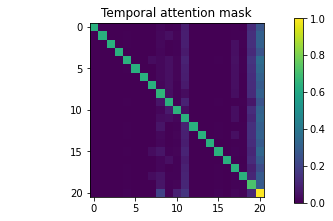

In [58]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('Temporal attention mask')
plt.imshow(att_mask)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

In [45]:
# Attention Rollout
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from src.utils.utility import preparing_video_dataset
from src.dataset import DatasetForVideo
from src.models.ViViT import ViViT
from typing import List, Literal
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

def rollout(attentions : List[torch.Tensor], discard_ratio : float, head_fusion : Literal["mean", 'max', 'min']):
    result = torch.eye(attentions[0].size()[-1]).unsqueeze(0)
    result = result.repeat((21,1,1))
    
    with torch.no_grad():
        for attention in attentions:
            
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"
            
            # attention_heads_fused : (21, 1, 17, 17)
            flat = attention_heads_fused.view(attention_heads_fused.size()[0], -1)
            
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim = -1, largest = False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            
            I = torch.eye(attention.size(-1)).unsqueeze(0).repeat((21,1,1))
            a = (attention_heads_fused + 1.0 * I) / 2.0
            
            result = torch.bmm(a, result)
            
    mask = result[:,0,1:]
    width = int(mask.size()[-1] ** 0.5)
    
    mask = mask.reshape(result.size()[0], 1, width, width)
    mask_interp = np.zeros((result.size()[0], 1, 128, 128))
    
    for idx in range(result.size()[0]):
        mask_interp[idx] = F.interpolate(mask[idx].view(1,1,width,width), size = (128,128), mode='bilinear', align_corners=False).numpy()

    mask_final = mask_interp / np.max(mask_interp)
    mask_final = np.max(mask_final, axis = 0).reshape(128,128,1)
    return mask_final

class ViViTAttentionRollout:
    def __init__(self, model : nn.Module, layer_name = '0.fn.to_qkv', head_fusion = 'max', discard_ratio = 0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
    
        for name, module in model.named_modules():
            if layer_name in name and "space_transformer" in name:
                module.register_forward_hook(self.get_attention)
        
        self.attentions = []
    
    def get_attention(self, module:nn.Module, input:torch.Tensor, output:torch.Tensor):
        
        h = self.model.n_heads
        output = torch.chunk(output, 3, -1)
        q,k,v = map(lambda t : rearrange(t, 'b n (h d) -> b h n d', h = h), output)
        
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.model.d_head ** (-0.5)
        attn = torch.softmax(dots, dim = -1)
        self.attentions.append(attn.cpu())
        
        # self.attentions.append(output.cpu())
    
    def __call__(self, input_tensor : torch.Tensor):
        self.attentions = []
        
        with torch.no_grad():
            output = self.model(input_tensor)
        
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

model = ViViT(
    image_size = 128,
    patch_size = 16,
    n_classes = 2,
    n_frames = 21,
    dim = 128,
    depth = 2,
    n_heads = 4,
    pool = "mean",
    in_channels = 3,
    d_head = 64,
    dropout = 0.1,
    embedd_dropout=0.1,
    scale_dim = 8
)

save_best_dir = "./weights/ViViT-exp_clip_21_dist_3_Focal_RS_DRW_seed_42_best.pt"
model.load_state_dict(torch.load(save_best_dir, map_location=torch.device('cpu')))

root_dir = "./dataset/temp"
shot_train, shot_valid, shot_test = preparing_video_dataset(root_dir)
df_disrupt = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv")
    
train_data = DatasetForVideo(shot_train, df_disrupt, augmentation = False, augmentation_args=None, crop_size = 128, seq_len = 21, dist = 1)
train_loader = DataLoader(train_data, batch_size = 1, num_workers = 1)

ViViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1=16, p2=16)
    (1): Linear(in_features=768, out_features=128, bias=True)
  )
  (space_transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (fn): Attention(
            (to_qkv): Linear(in_features=128, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=128, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (1): PreNorm(
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=1024, bias=True)
              (1): GELU()
              (2): Dropout(p=0.1, inplace=False)
              (3): Linear(in_features=1024, out_features=128, bias=True)
              (4): Dropout(p=0.1, in

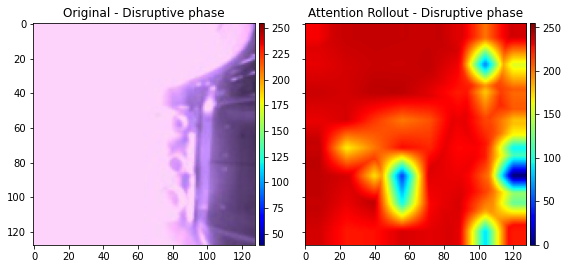

In [44]:
# plot the attention mapping
import cv2
import numpy as np
import matplotlib.pyplot as plt

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

for idx, (sample_data, sample_label) in enumerate(train_loader):
    if sample_label == torch.Tensor([0]) and idx > 64:
        break
    
rollout_model = ViViTAttentionRollout(model,head_fusion = 'max', discard_ratio=0.1)
att_mask = rollout_model(sample_data.to(device))

att_heatmap = cv2.applyColorMap(np.uint8(255 * att_mask), cv2.COLORMAP_JET)

img = sample_data[:,:,-2,:,:].cpu().squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

att_result = att_heatmap / np.max(att_heatmap)
att_result = np.uint8(255 * att_result)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('Attention Rollout - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(att_result[:,:,::1], cmap = plt.cm.get_cmap('jet'))

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar
 
add_colorbar(im1)
add_colorbar(im2)

fig.tight_layout()
model.cpu()

ViViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1=16, p2=16)
    (1): Linear(in_features=768, out_features=128, bias=True)
  )
  (space_transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (fn): Attention(
            (to_qkv): Linear(in_features=128, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=128, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (1): PreNorm(
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=1024, bias=True)
              (1): GELU()
              (2): Dropout(p=0.1, inplace=False)
              (3): Linear(in_features=1024, out_features=128, bias=True)
              (4): Dropout(p=0.1, in

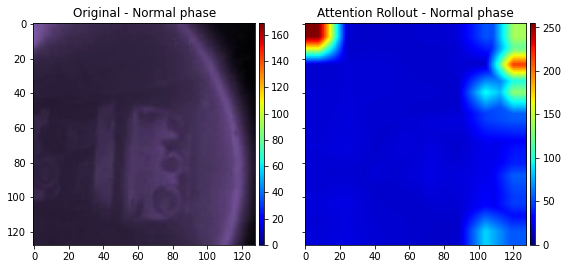

In [52]:
# plot the attention mapping
import cv2
import numpy as np
import matplotlib.pyplot as plt

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

for idx, (sample_data, sample_label) in enumerate(train_loader):
    if sample_label == torch.Tensor([1]):
        break
    
rollout_model = ViViTAttentionRollout(model,head_fusion = 'max', discard_ratio=0.25)
att_mask = rollout_model(sample_data.to(device))

att_heatmap = cv2.applyColorMap(np.uint8(255 * att_mask), cv2.COLORMAP_JET)

img = sample_data[:,:,-1,:,:].cpu().squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

att_result = att_heatmap / np.max(att_heatmap)
att_result = np.uint8(255 * att_result)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('Attention Rollout - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(att_result[:,:,::-1], cmap = plt.cm.get_cmap('jet'))

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar
 
add_colorbar(im1)
add_colorbar(im2)

fig.tight_layout()
model.cpu()

/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


activations :  torch.Size([1, 128, 3, 8, 8])
gradients :  torch.Size([1, 128, 3, 8, 8])
grad cam map :  torch.Size([1, 1, 3, 8, 8])


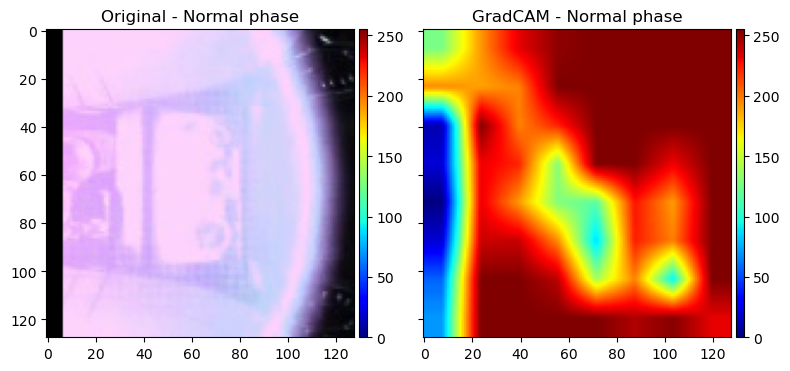

In [1]:
# GradCAM : R2Plus1D case
import torch
import pandas as pd
from torch.utils.data import DataLoader
from src.utils.utility import preparing_video_dataset
from src.dataset import DatasetForVideo2
from src.models.R2Plus1D import R2Plus1DClassifier

root_dir = "./dataset/temp"
shot_train, shot_valid, shot_test = preparing_video_dataset(root_dir)
df_disrupt = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv")
    
train_data = DatasetForVideo2(shot_train, df_disrupt, augmentation = True, augmentation_args=None, crop_size = 128, seq_len = 21, dist = 5)
train_loader = DataLoader(train_data, batch_size = 1, num_workers = 1)

model = R2Plus1DClassifier(
    input_size  = (3,21,128,128),
    num_classes = 2, 
    layer_sizes = [1,2,2,1],
    pretrained = False, 
    alpha = 1.0
)

save_best_dir = "./weights/R2Plus1D_clip_21_dist_5_Focal_RS_RW_last.pt"
model.load_state_dict(torch.load(save_best_dir))

device = "cuda:1" if torch.cuda.is_available() else "cpu"
model.to(device)

# activations
feature_blobs = []

# gradients
backward_feature = []

import torch.nn as nn

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module:nn.Module, input, output):
    feature_blobs.append(output.cpu().data)
    

# Grad-CAM
def backward_hook(module:nn.Module, input, output):
    backward_feature.append(output[0])
    
finalconv_name = "conv5"

model._modules['res2plus1d'].get_submodule("conv5").register_forward_hook(hook_feature)
model._modules['res2plus1d'].get_submodule("conv5").register_backward_hook(backward_hook)

for idx, (sample_data, sample_label) in enumerate(train_loader):
    if sample_label == torch.Tensor([1]):
        break
    
model.eval()
sample_logit = model(sample_data.to(device))
sample_data.cpu()
sample_output = torch.nn.functional.softmax(sample_logit, dim = 1).data.squeeze()

score = sample_logit[:,0].squeeze()
score.backward(retain_graph = True)

activations = feature_blobs[-1].to(device) # (1, 512, 7, 7), forward activations
gradients = backward_feature[-1] # (1, 512, 7, 7), backward gradients

print("activations : ", activations.size())
print("gradients : ", gradients.size())

alpha = gradients.mean(2) # time axis average
alpha = alpha.view(1, 128, -1).mean(2) # average for all spatial axis
weights = alpha.view(1, 128, 1, 1, 1)

import torch.nn.functional as F

grad_cam_map = (weights*activations).sum(1, keepdim = True)
grad_cam_map = F.relu(grad_cam_map).view(1,1,3,8,8)

print("grad cam map : ", grad_cam_map.size())

grad_cam_map_interp = torch.empty((1,1,3,128,128))

for idx in range(3):
   grad_cam_map_interp[:,:,idx,:,:] = F.interpolate(grad_cam_map[:,:,idx,:,:], size=(128, 128), mode='bilinear', align_corners=False)

grad_cam_map_interp = grad_cam_map_interp.mean(2)
map_min, map_max = grad_cam_map_interp.min(), grad_cam_map_interp.max()
grad_cam_map = (grad_cam_map_interp - map_min).div(map_max - map_min).data

import cv2
import numpy as np
import matplotlib.pyplot as plt

grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET)

# normalize [90.0, 98.0, 102.0]
img = sample_data[:,:,-1,:,:].squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

# grad_result = grad_heatmap + img
grad_result = grad_heatmap
grad_result = grad_result / np.max(grad_result)
grad_result = np.uint8(255 * grad_result)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('GradCAM - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(grad_result, cmap = plt.cm.get_cmap('jet'))

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

add_colorbar(im1)
add_colorbar(im2)
fig.tight_layout()

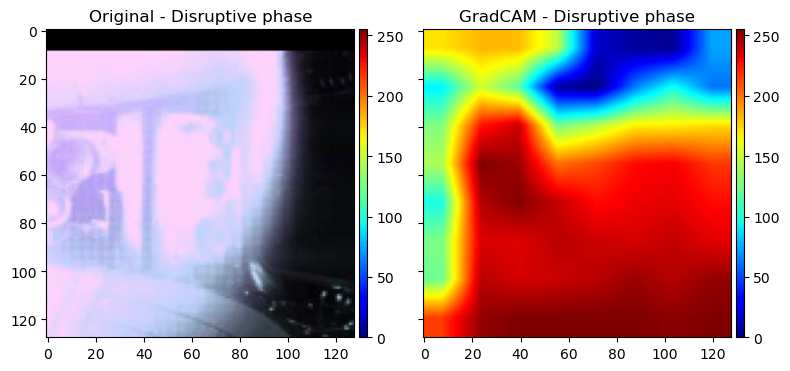

In [6]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model.to(device)

# activations
feature_blobs = []

# gradients
backward_feature = []

import torch.nn as nn

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module:nn.Module, input, output):
    feature_blobs.append(output.cpu().data)
    

# Grad-CAM
def backward_hook(module:nn.Module, input, output):
    backward_feature.append(output[0])
    
finalconv_name = "conv5"

model._modules['res2plus1d'].get_submodule("conv5").register_forward_hook(hook_feature)
model._modules['res2plus1d'].get_submodule("conv5").register_backward_hook(backward_hook)

for idx, (sample_data, sample_label) in enumerate(train_loader):
    if sample_label == torch.Tensor([0]):
        break
    
model.eval()
sample_logit = model(sample_data.to(device))
sample_data.cpu()
sample_output = torch.nn.functional.softmax(sample_logit, dim = 1).data.squeeze()

score = sample_logit[:,0].squeeze()
score.backward(retain_graph = True)

activations = feature_blobs[-1].to(device) # (1, 512, 7, 7), forward activations
gradients = backward_feature[-1] # (1, 512, 7, 7), backward gradients

alpha = gradients.mean(2) # time axis average
alpha = alpha.view(1, 128, -1).mean(2) # average for all spatial axis
weights = alpha.view(1, 128, 1, 1, 1)

import torch.nn.functional as F

grad_cam_map = (weights*activations).sum(1, keepdim = True)
grad_cam_map = F.relu(grad_cam_map).view(1,1,3,8,8)

grad_cam_map_interp = torch.empty((1,1,3,128,128))

for idx in range(3):
   grad_cam_map_interp[:,:,idx,:,:] = F.interpolate(grad_cam_map[:,:,idx,:,:], size=(128, 128), mode='bilinear', align_corners=False)

grad_cam_map_interp = grad_cam_map_interp.mean(2)
map_min, map_max = grad_cam_map_interp.min(), grad_cam_map_interp.max()
grad_cam_map = (grad_cam_map_interp - map_min).div(map_max - map_min).data
grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET)

# normalize [90.0, 98.0, 102.0]
img = sample_data[:,:,-3,:,:].squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

# grad_result = grad_heatmap + img
grad_result = grad_heatmap
grad_result = grad_result / np.max(grad_result)
grad_result = np.uint8(255 * grad_result)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('GradCAM - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(grad_result, cmap = plt.cm.get_cmap('jet'))

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

add_colorbar(im1)
add_colorbar(im2)
fig.tight_layout()

In [1]:
# GradCAM : SlowFast
import torch
import pandas as pd
from torch.utils.data import DataLoader
from src.utils.utility import preparing_video_dataset
from src.dataset import DatasetForVideo2
from src.models.resnet import Bottleneck3D
from src.models.slowfast import SlowFast

root_dir = "./dataset/temp"
shot_train, shot_valid, shot_test = preparing_video_dataset(root_dir)
df_disrupt = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv")
    
train_data = DatasetForVideo2(shot_train, df_disrupt, augmentation = True, augmentation_args=None, crop_size = 128, seq_len = 20, dist = 5)
train_loader = DataLoader(train_data, batch_size = 1, num_workers = 1)

model = SlowFast(
    input_shape = (3, 20, 128, 128),
    block = Bottleneck3D,
    layers = [1,2,2,1],
    alpha = 4,
    tau_fast = 1,
    num_classes = 2,
    alpha_elu = 1.0,
)

save_best_dir = "./weights/SlowFast_clip_20_dist_5_Focal_RS_RW_last.pt"
model.load_state_dict(torch.load(save_best_dir))

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

# activations 
feature_blobs_sn = []
feature_blobs_fn = []

# gradients
backward_feature_sn = []
backward_feature_fn = []

import torch.nn as nn

def hook_feature_sn(module:nn.Module, input, output):
    feature_blobs_sn.append(output.cpu().data)
    
# Grad-CAM
def backward_hook_sn(module:nn.Module, input, output):
    backward_feature_sn.append(output[0])
    
def hook_feature_fn(module:nn.Module, input, output):
    feature_blobs_fn.append(output.cpu().data)
    
# Grad-CAM
def backward_hook_fn(module:nn.Module, input, output):
    backward_feature_fn.append(output[0])
    
# SlowFast model has 2 stream line
# SlowNet case
# model._modules['encoder']._modules['slownet']._modules['layer4']._modules['0'].get_submodule("conv3").register_forward_hook(hook_feature_sn)
# model._modules['encoder']._modules['slownet']._modules['layer4']._modules['0'].get_submodule("conv3").register_backward_hook(backward_hook_sn)

model._modules['encoder']._modules['slownet']._modules['layer4']._modules['0']._modules['downsample'].get_submodule("0").register_forward_hook(hook_feature_sn)
model._modules['encoder']._modules['slownet']._modules['layer4']._modules['0']._modules['downsample'].get_submodule("0").register_backward_hook(backward_hook_sn)

# FastNet
model._modules['encoder']._modules['fastnet'].get_submodule('l_layer3').register_forward_hook(hook_feature_fn)
model._modules['encoder']._modules['fastnet'].get_submodule('l_layer3').register_backward_hook(backward_hook_fn)

/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
for idx, (sample_data, sample_label) in enumerate(train_loader):
    if sample_label == torch.Tensor([1]):
        break
    
# sample_data, sample_label = next(iter(train_loader))

model.eval()
sample_logit = model(sample_data.to(device))
sample_data.cpu()
sample_output = torch.nn.functional.softmax(sample_logit, dim = 1).data.squeeze()

score = sample_logit[:,0].squeeze()
score.backward(retain_graph = True)

activations_sn = feature_blobs_sn[-1].to(device) # (1, 512, 7, 7), forward activations
gradients_sn = backward_feature_sn[-1] # (1, 512, 7, 7), backward gradients

print("SlowNet | activations : ", activations_sn.size())
print("SlowNet | gradients : ", gradients_sn.size())

activations_fn = feature_blobs_fn[-1].to(device) # (1, 512, 7, 7), forward activations
gradients_fn = backward_feature_fn[-1] # (1, 512, 7, 7), backward gradients

print("FastNet | activations : ", activations_fn.size())
print("FastNet | gradients : ", gradients_fn.size())

alpha = gradients_sn.mean(2) # time axis average
alpha = alpha.view(1, 512, -1).mean(2) # average for all spatial axis
weights_sn = alpha.view(1, 512, 1, 1, 1)

alpha = gradients_fn.mean(2) # time axis average
alpha = alpha.view(1, 64, -1).mean(2) # average for all spatial axis
weights_fn = alpha.view(1, 64, 1, 1, 1)

/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


SlowNet | activations :  torch.Size([1, 512, 5, 4, 4])
SlowNet | gradients :  torch.Size([1, 512, 5, 4, 4])
FastNet | activations :  torch.Size([1, 64, 5, 8, 8])
FastNet | gradients :  torch.Size([1, 64, 5, 8, 8])


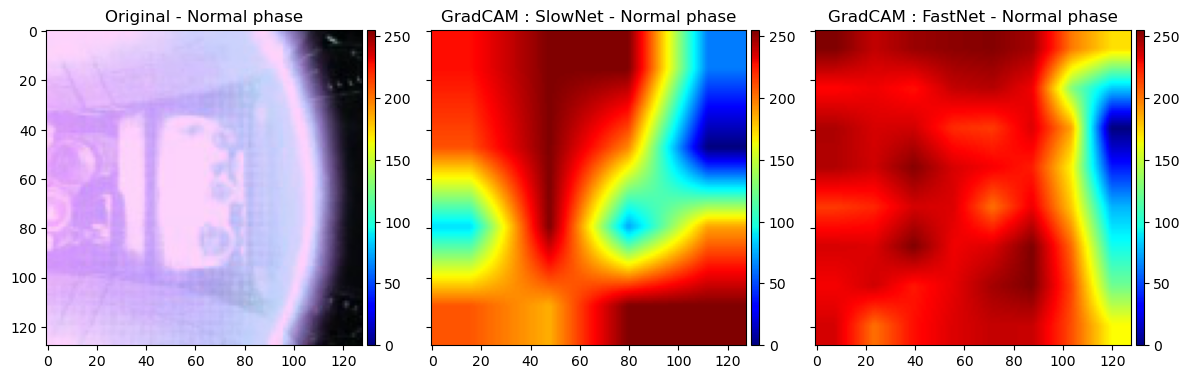

In [3]:
import torch.nn.functional as F

# case : SlowNet 
grad_cam_map = (weights_sn*activations_sn).sum(1, keepdim = True)
grad_cam_map = F.relu(grad_cam_map).view(1,1,5,4,4)

grad_cam_map_interp = torch.empty((1,1,5,128,128))

for idx in range(5):
   grad_cam_map_interp[:,:,idx,:,:] = F.interpolate(grad_cam_map[:,:,idx,:,:], size=(128, 128), mode='bilinear', align_corners=False)

grad_cam_map_interp = grad_cam_map_interp.mean(2)
map_min, map_max = grad_cam_map_interp.min(), grad_cam_map_interp.max()
grad_cam_map_sn = (grad_cam_map_interp - map_min).div(map_max - map_min).data

# case : FastNet 
grad_cam_map = (weights_fn*activations_fn).sum(1, keepdim = True)
grad_cam_map = F.relu(grad_cam_map).view(1,1,5,8,8)

grad_cam_map_interp = torch.empty((1,1,5,128,128))

for idx in range(5):
   grad_cam_map_interp[:,:,idx,:,:] = F.interpolate(grad_cam_map[:,:,idx,:,:], size=(128, 128), mode='bilinear', align_corners=False)

grad_cam_map_interp = grad_cam_map_interp.mean(2)
map_min, map_max = grad_cam_map_interp.min(), grad_cam_map_interp.max()
grad_cam_map_fn = (grad_cam_map_interp - map_min).div(map_max - map_min).data

# visualization
import cv2
import numpy as np
import matplotlib.pyplot as plt

grad_heatmap_sn = cv2.applyColorMap(np.uint8(255 * grad_cam_map_sn.squeeze().cpu()), cv2.COLORMAP_JET)
grad_heatmap_fn = cv2.applyColorMap(np.uint8(255 * grad_cam_map_fn.squeeze().cpu()), cv2.COLORMAP_JET)

img = sample_data[:,:,-1,:,:].squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

grad_result_sn= grad_heatmap_sn 
grad_result_sn= grad_result_sn / np.max(grad_result_sn)
grad_result_sn= np.uint8(255 * grad_result_sn)

grad_result_fn= grad_heatmap_fn 
grad_result_fn= grad_result_fn / np.max(grad_result_fn)
grad_result_fn= np.uint8(255 * grad_result_fn)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 12), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('GradCAM : SlowNet - {}'.format(title))
ax3.set_title('GradCAM : FastNet - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(grad_result_sn, cmap = plt.cm.get_cmap('jet'))
im3 = ax3.imshow(grad_result_fn, cmap = plt.cm.get_cmap('jet'))

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar
 
add_colorbar(im1)
add_colorbar(im2)
add_colorbar(im3)

fig.tight_layout()

SlowNet | activations :  torch.Size([1, 512, 5, 4, 4])
SlowNet | gradients :  torch.Size([1, 512, 5, 4, 4])
FastNet | activations :  torch.Size([1, 64, 5, 8, 8])
FastNet | gradients :  torch.Size([1, 64, 5, 8, 8])


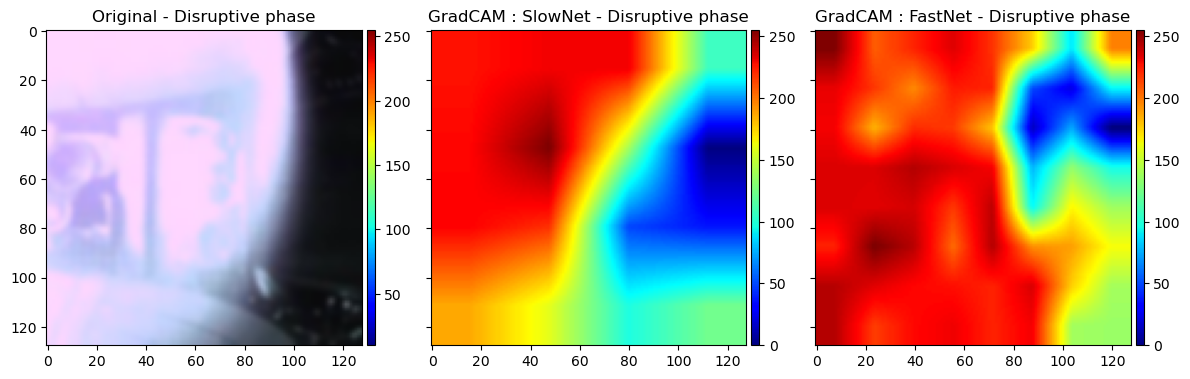

In [5]:
for idx, (sample_data, sample_label) in enumerate(train_loader):
    if sample_label == torch.Tensor([0]):
        break
    
# sample_data, sample_label = next(iter(train_loader))

model.eval()
sample_logit = model(sample_data.to(device))
sample_data.cpu()
sample_output = torch.nn.functional.softmax(sample_logit, dim = 1).data.squeeze()

score = sample_logit[:,0].squeeze()
score.backward(retain_graph = True)

activations_sn = feature_blobs_sn[-1].to(device) # (1, 512, 7, 7), forward activations
gradients_sn = backward_feature_sn[-1] # (1, 512, 7, 7), backward gradients

print("SlowNet | activations : ", activations_sn.size())
print("SlowNet | gradients : ", gradients_sn.size())

activations_fn = feature_blobs_fn[-1].to(device) # (1, 512, 7, 7), forward activations
gradients_fn = backward_feature_fn[-1] # (1, 512, 7, 7), backward gradients

print("FastNet | activations : ", activations_fn.size())
print("FastNet | gradients : ", gradients_fn.size())

alpha = gradients_sn.mean(2) # time axis average
alpha = alpha.view(1, 512, -1).mean(2) # average for all spatial axis
weights_sn = alpha.view(1, 512, 1, 1, 1)

alpha = gradients_fn.mean(2) # time axis average
alpha = alpha.view(1, 64, -1).mean(2) # average for all spatial axis
weights_fn = alpha.view(1, 64, 1, 1, 1)

import torch.nn.functional as F

# case : SlowNet 
grad_cam_map = (weights_sn*activations_sn).sum(1, keepdim = True)
grad_cam_map = F.relu(grad_cam_map).view(1,1,5,4,4)

grad_cam_map_interp = torch.empty((1,1,5,128,128))

for idx in range(5):
   grad_cam_map_interp[:,:,idx,:,:] = F.interpolate(grad_cam_map[:,:,idx,:,:], size=(128, 128), mode='bilinear', align_corners=False)

grad_cam_map_interp = grad_cam_map_interp.mean(2)
map_min, map_max = grad_cam_map_interp.min(), grad_cam_map_interp.max()
grad_cam_map_sn = (grad_cam_map_interp - map_min).div(map_max - map_min).data

# case : FastNet 
grad_cam_map = (weights_fn*activations_fn).sum(1, keepdim = True)
grad_cam_map = F.relu(grad_cam_map).view(1,1,5,8,8)

grad_cam_map_interp = torch.empty((1,1,5,128,128))

for idx in range(5):
   grad_cam_map_interp[:,:,idx,:,:] = F.interpolate(grad_cam_map[:,:,idx,:,:], size=(128, 128), mode='bilinear', align_corners=False)

grad_cam_map_interp = grad_cam_map_interp.mean(2)
map_min, map_max = grad_cam_map_interp.min(), grad_cam_map_interp.max()
grad_cam_map_fn = (grad_cam_map_interp - map_min).div(map_max - map_min).data

# visualization
import cv2
import numpy as np
import matplotlib.pyplot as plt

grad_heatmap_sn = cv2.applyColorMap(np.uint8(255 * grad_cam_map_sn.squeeze().cpu()), cv2.COLORMAP_JET)
grad_heatmap_fn = cv2.applyColorMap(np.uint8(255 * grad_cam_map_fn.squeeze().cpu()), cv2.COLORMAP_JET)

img = sample_data[:,:,-3,:,:].squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

grad_result_sn= grad_heatmap_sn 
grad_result_sn= grad_result_sn / np.max(grad_result_sn)
grad_result_sn= np.uint8(255 * grad_result_sn)

grad_result_fn= grad_heatmap_fn 
grad_result_fn= grad_result_fn / np.max(grad_result_fn)
grad_result_fn= np.uint8(255 * grad_result_fn)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 12), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('GradCAM : SlowNet - {}'.format(title))
ax3.set_title('GradCAM : FastNet - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(grad_result_sn, cmap = plt.cm.get_cmap('jet'))
im3 = ax3.imshow(grad_result_fn, cmap = plt.cm.get_cmap('jet'))

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar
 
add_colorbar(im1)
add_colorbar(im2)
add_colorbar(im3)

fig.tight_layout()

In [1]:
# Multimodal model case
# Attention Rollout
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from src.utils.utility import preparing_multi_data
from src.dataset import MultiModalDataset
from typing import List, Literal
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from src.models.MultiModal import MultiModalModel

def rollout(attentions : List[torch.Tensor], discard_ratio : float, head_fusion : Literal["mean", 'max', 'min']):
    result = torch.eye(attentions[0].size()[-1]).unsqueeze(0)
    result = result.repeat((21,1,1))
    
    with torch.no_grad():
        for attention in attentions:
            
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"
            
            # attention_heads_fused : (21, 1, 17, 17)
            flat = attention_heads_fused.view(attention_heads_fused.size()[0], -1)
            
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim = -1, largest = False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            
            I = torch.eye(attention.size(-1)).unsqueeze(0).repeat((21,1,1))
            a = (attention_heads_fused + 1.0 * I) / 2.0
            
            result = torch.bmm(a, result)
            
    mask = result[:,0,1:]
    width = int(mask.size()[-1] ** 0.5)
    # mask = mask.sum(0, keepdim=True).view(1,1,width,width)
    
    mask = mask.reshape(result.size()[0], 1, width, width)
    mask_interp = np.zeros((result.size()[0], 1, 128, 128))
    
    for idx in range(result.size()[0]):
        mask_interp[idx] = F.interpolate(mask[idx].view(1,1,width,width), size = (128,128), mode='bilinear', align_corners=False).numpy()

    mask_final = mask_interp / np.max(mask_interp)
    mask_final = np.max(mask_final, axis = 0).reshape(128,128,1)
    return mask_final

class ViViTAttentionRollout:
    def __init__(self, model : nn.Module, layer_name = '0.fn.to_qkv', head_fusion = 'max', discard_ratio = 0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
    
        for name, module in model.encoder_video.named_modules():
            if layer_name in name and "space_transformer" in name:
                module.register_forward_hook(self.get_attention)
        
        self.attentions = []
    
    def get_attention(self, module:nn.Module, input:torch.Tensor, output:torch.Tensor):
        
        h = self.model.encoder_video.n_heads
        output = torch.chunk(output, 3, -1)
        q,k,v = map(lambda t : rearrange(t, 'b n (h d) -> b h n d', h = h), output)
        
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.model.encoder_video.d_head ** (-0.5)
        attn = torch.softmax(dots, dim = -1)
        self.attentions.append(attn.cpu())
        
        # self.attentions.append(output.cpu())
    
    def __call__(self, data, device):
        self.attentions = []
        
        with torch.no_grad():
            data_video = data['video'].to(device)
            data_0D = data['0D'].to(device)
            output = self.model(data_video, data_0D)
        
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

args_video = {
    "image_size" : 128, 
    "patch_size" : 16, 
    "n_frames" : 21, 
    "dim": 128, 
    "depth" : 2, 
    "n_heads" : 4, 
    "pool" : 'cls', 
    "in_channels" : 3, 
    "d_head" : 64, 
    "dropout" : 0.1,
    "embedd_dropout": 0.1, 
    "scale_dim" : 8,
}

args_0D = {
    "n_features" : 12, 
    "feature_dims" : 128,
    "max_len" : 21, 
    "n_layers" : 4,
    "n_heads" : 8,
    "dim_feedforward": 512, 
    "dropout" : 0.25,
}

model = MultiModalModel(
    2,
    21,
    args_video,
    args_0D
)

save_best_dir = "./weights/Multi-Modal_clip_21_dist_3_Focal_RS_DRW_seed_42_best.pt"
model.load_state_dict(torch.load(save_best_dir))

root_dir = "./dataset/temp"
df_disrupt = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv")

ts_cols = [
        '\\q95', '\\ipmhd', '\\kappa', 
        '\\tritop', '\\tribot','\\betap',
        '\\betan','\\li', '\\WTOT_DLM03', 
        '\\ne_inter01', '\\TS_NE_CORE_AVG', '\\TS_TE_CORE_AVG',
]

ts_filepath = "./dataset/KSTAR_Disruption_ts_data_5ms.csv"
(shot_train, ts_train), (shot_valid, ts_valid), (shot_test, ts_test), scaler = preparing_multi_data(root_dir, ts_filepath, ts_cols, scaler = 'Robust')
kstar_shot_list = pd.read_csv('./dataset/KSTAR_Disruption_Shot_List_extend.csv', encoding = "euc-kr")

train_data = MultiModalDataset(shot_train, df_disrupt, ts_train, ts_cols, augmentation=False, augmentation_args=None, crop_size=128, seq_len =21, dist = 3, dt = 1 / 210, scaler = scaler, tau = 4)
train_loader = DataLoader(train_data, batch_size = 1, num_workers = 1)

/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
extract the null data: 100%|██████████| 227/227 [00:01<00:00, 135.58it/s]


# check | video data : 9154, 0D data : 9154


MultiModalModel(
  (encoder_video): ViViTEncoder(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1=16, p2=16)
      (1): Linear(in_features=768, out_features=128, bias=True)
    )
    (space_transformer): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): Attention(
              (to_qkv): Linear(in_features=128, out_features=768, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=256, out_features=128, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (net): Sequential(
                (0): Linear(in_features=128, out_features=1024, bias=True)
                (1): GELU(approximate='none')
                (2): Dropout(p=0.1, inplace=False)
  

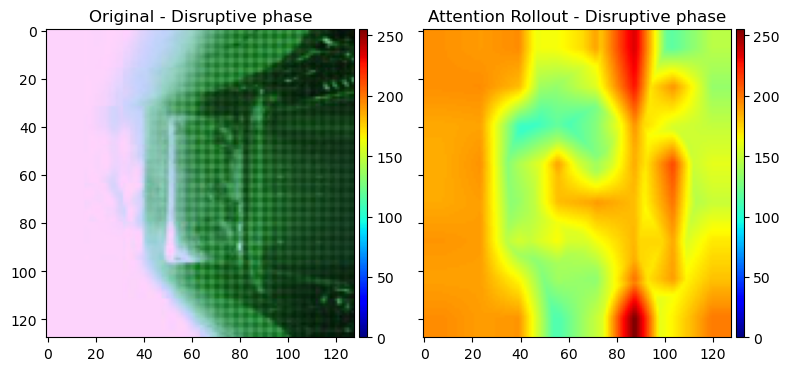

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

device = "cuda:1" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

for idx, (samples, sample_label) in enumerate(train_loader):
    if sample_label == torch.Tensor([0]):
        break

rollout_model = ViViTAttentionRollout(model,head_fusion = 'max', discard_ratio=0.9)
att_mask = rollout_model(samples, device)

att_heatmap = cv2.applyColorMap(np.uint8(255 * att_mask), cv2.COLORMAP_JET)

sample_data = samples['video']
img = sample_data[:,:,-1,:,:].cpu().squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

att_result = att_heatmap / np.max(att_heatmap)
att_result = np.uint8(255 * att_result)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('Attention Rollout - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(att_result[:,:,::-1], cmap = plt.cm.get_cmap('jet'))

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar
 
add_colorbar(im1)
add_colorbar(im2)

fig.tight_layout()
model.cpu()

MultiModalModel(
  (encoder_video): ViViTEncoder(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1=16, p2=16)
      (1): Linear(in_features=768, out_features=128, bias=True)
    )
    (space_transformer): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): Attention(
              (to_qkv): Linear(in_features=128, out_features=768, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=256, out_features=128, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (net): Sequential(
                (0): Linear(in_features=128, out_features=1024, bias=True)
                (1): GELU(approximate='none')
                (2): Dropout(p=0.1, inplace=False)
  

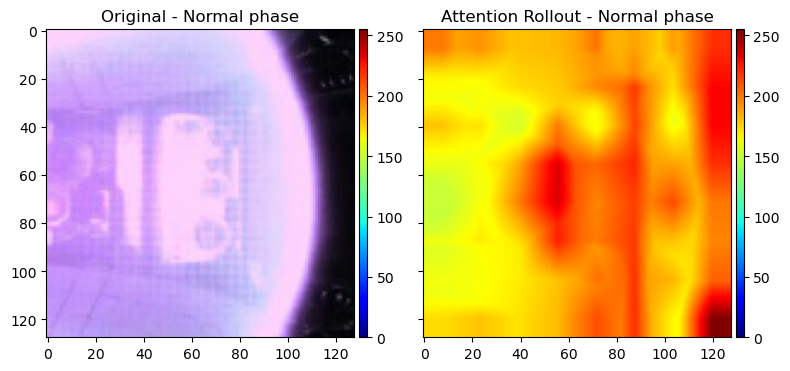

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

device = "cuda:3" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

for idx, (samples, sample_label) in enumerate(train_loader):
    if sample_label == torch.Tensor([1]) and idx > 64:
        break

rollout_model = ViViTAttentionRollout(model,head_fusion = 'max', discard_ratio=0.9)
att_mask = rollout_model(samples, device)

att_heatmap = cv2.applyColorMap(np.uint8(255 * att_mask), cv2.COLORMAP_JET)

sample_data = samples['video']
img = sample_data[:,:,-2,:,:].cpu().squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

att_result = att_heatmap / np.max(att_heatmap)
att_result = np.uint8(255 * att_result)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('Attention Rollout - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(att_result[:,:,::-1], cmap = plt.cm.get_cmap('jet'))

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar
 
add_colorbar(im1)
add_colorbar(im2)

fig.tight_layout()
model.cpu()

In [90]:
# Multimodal model case
# Attention Rollout
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from src.utils.utility import preparing_multi_data
from src.dataset import MultiModalDataset
from typing import List, Literal
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from src.models.MultiModal import MultiModalModel

def rollout2(attentions : List[torch.Tensor], discard_ratio : float, head_fusion : Literal["mean", 'max', 'min']):
    result = torch.eye(attentions[0].size()[-1]).unsqueeze(0)
    result = result.repeat((84,1,1))
    
    with torch.no_grad():
        for attention in attentions:
            
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"
            
            # attention_heads_fused : (21, 1, 17, 17)
            flat = attention_heads_fused.view(attention_heads_fused.size()[0], -1)
            
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim = -1, largest = False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            
            I = torch.eye(attention.size(-1)).unsqueeze(0).repeat((84,1,1))
            a = (attention_heads_fused + 1.0 * I) / 2.0
            
            result = torch.bmm(a, result)
            
    mask = result[:,0,1:]
    width = int(mask.size()[-1] ** 0.5)
    # mask = mask.sum(0, keepdim=True).view(1,1,width,width)
    
    mask = mask.reshape(result.size()[0], 1, width, width)
    mask_interp = np.zeros((result.size()[0], 1, 128, 128))
    
    for idx in range(result.size()[0]):
        mask_interp[idx] = F.interpolate(mask[idx].view(1,1,width,width), size = (128,128), mode='bilinear', align_corners=False).numpy()

    mask_final = mask_interp / np.max(mask_interp)
    mask_final = np.max(mask_final, axis = 0).reshape(128,128,1)
    return mask_final

class ViViTAttentionRollout2:
    def __init__(self, model : nn.Module, layer_name = '0.fn.to_qkv', head_fusion = 'max', discard_ratio = 0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
    
        for name, module in model.encoder_video.named_modules():
            if layer_name in name and "space_transformer" in name:
                module.register_forward_hook(self.get_attention)
        
        self.attentions = []
    
    def get_attention(self, module:nn.Module, input:torch.Tensor, output:torch.Tensor):
        
        h = self.model.encoder_video.n_heads
        output = torch.chunk(output, 3, -1)
        q,k,v = map(lambda t : rearrange(t, 'b n (h d) -> b h n d', h = h), output)
        
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.model.encoder_video.d_head ** (-0.5)
        attn = torch.softmax(dots, dim = -1)
        self.attentions.append(attn.cpu())
    
    def __call__(self, data, device):
        self.attentions = []
        
        with torch.no_grad():
            data_video = data['video'].to(device)
            data_0D = data['0D'].to(device)
            output = self.model(data_video, data_0D)
        
        return rollout2(self.attentions, self.discard_ratio, self.head_fusion)

args_video = {
    "image_size" : 128, 
    "patch_size" : 16, 
    "n_frames" : 84, 
    "dim": 128, 
    "depth" : 2, 
    "n_heads" : 4, 
    "pool" : 'mean', 
    "in_channels" : 3, 
    "d_head" : 64, 
    "dropout" : 0.1,
    "embedd_dropout": 0.1, 
    "scale_dim" : 8,
}

args_0D = {
    "n_features" : 18, 
    "feature_dims" : 128,
    "max_len" : 84, 
    "n_layers" : 4,
    "n_heads" : 8,
    "dim_feedforward": 1024, 
    "dropout" : 0.1,
}

root_dir = "./dataset/temp"
df_disrupt = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv")

from src.config import Config
config = Config()
ts_cols = config.input_features

ts_filepath = "./dataset/KSTAR_Disruption_ts_data_5ms.csv"
(shot_train, ts_train), (shot_valid, ts_valid), (shot_test, ts_test), scaler = preparing_multi_data(root_dir, ts_filepath, ts_cols, scaler = 'Robust')
kstar_shot_list = pd.read_csv('./dataset/KSTAR_Disruption_Shot_List_extend.csv', encoding = "euc-kr")

train_data = MultiModalDataset(shot_train, df_disrupt, ts_train, ts_cols, augmentation=False, augmentation_args=None, crop_size=128, seq_len =84, dist = 0, dt = 1 / 210, scaler = scaler, tau = 1)
train_loader = DataLoader(train_data, batch_size = 1, num_workers = 1)

/home/zinzinbin/anaconda3/envs/research-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
extract the null data / short time data: 100%|██████████| 213/213 [00:01<00:00, 120.42it/s]


# check | video data : 6487, 0D data : 6487 | # of shot : 6487


ViViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1=16, p2=16)
    (1): Linear(in_features=768, out_features=128, bias=True)
  )
  (space_transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (fn): Attention(
            (to_qkv): Linear(in_features=128, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=128, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (1): PreNorm(
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=1024, bias=True)
              (1): GELU()
              (2): Dropout(p=0.1, inplace=False)
              (3): Linear(in_features=1024, out_features=128, bias=True)
              (4): Dropout(p=0.1, in

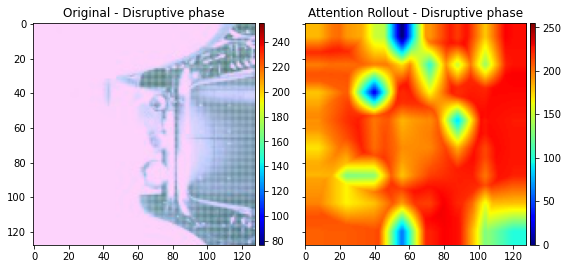

In [120]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


multi_model = MultiModalModel(
    2,
    args_video,
    args_0D
)

save_best_dir = "./weights/Multi-Modal_concat_clip_84_dist_5_Focal_RS_DRW_seed_42_best.pt"
multi_model.load_state_dict(torch.load(save_best_dir, map_location = "cpu"))

device = "cuda:1" if torch.cuda.is_available() else "cpu"
multi_model.to(device)
multi_model.eval()

for idx, (samples, sample_label) in enumerate(train_loader):
    if sample_label == torch.Tensor([0]):
        break

rollout_model = ViViTAttentionRollout2(multi_model, head_fusion = 'mean', discard_ratio=0.1)
att_mask = rollout_model(samples, device)

att_heatmap = cv2.applyColorMap(np.uint8(255 * att_mask), cv2.COLORMAP_JET)

sample_data = samples['video']
img = sample_data[:,:,-5,:,:].cpu().squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

att_result = att_heatmap / np.max(att_heatmap)
att_result = np.uint8(255 * att_result)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('Attention Rollout - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(att_result[:,:,::1], cmap = plt.cm.get_cmap('jet'))

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar
 
add_colorbar(im1)
add_colorbar(im2)

fig.tight_layout()
model.cpu()

name : space_transformer.layers.0.0.fn, name_ : to_out
name : space_transformer.layers.1.0.fn, name_ : to_out


ViViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1=16, p2=16)
    (1): Linear(in_features=768, out_features=128, bias=True)
  )
  (space_transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (fn): Attention(
            (to_qkv): Linear(in_features=128, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=128, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (1): PreNorm(
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=1024, bias=True)
              (1): GELU()
              (2): Dropout(p=0.1, inplace=False)
              (3): Linear(in_features=1024, out_features=128, bias=True)
              (4): Dropout(p=0.1, in

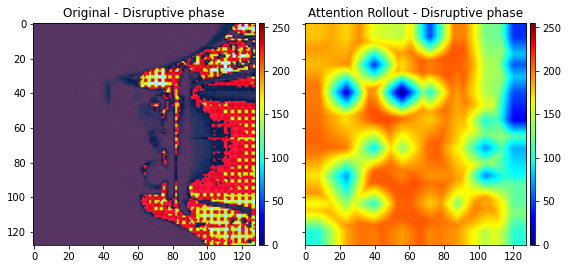

In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List, Literal, Optional
from src.models.ViViT import ViViT

model = ViViT(
    image_size = 128,
    patch_size = 16,
    n_classes = 2,
    n_frames = 21,
    dim = 128,
    depth = 2,
    n_heads = 4,
    pool = "mean",
    in_channels = 3,
    d_head = 64,
    dropout = 0.1,
    embedd_dropout=0.1,
    scale_dim = 8
)

save_best_dir = "./weights/ViViT_clip_21_dist_5_Focal_DRW_seed_42_best.pt"
model.load_state_dict(torch.load(save_best_dir, map_location=torch.device('cpu')))

for name, module in model.named_modules():
    for name_, module_ in module.named_children():
        if "to_out" in name_ and "space_transformer" in name:
            print("name : {}, name_ : {}".format(name, name_))

def rollout(attentions : List[torch.Tensor], discard_ratio : float, head_fusion : Literal["mean", 'max', 'min']):
    result = torch.eye(attentions[0].size()[-1]).unsqueeze(0)
    result = result.repeat((21,1,1))
    
    with torch.no_grad():
        for attention in attentions:
            
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"
            
            # attention_heads_fused : (21, 1, 17, 17)
            flat = attention_heads_fused.view(attention_heads_fused.size()[0], -1)
            
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim = -1, largest = False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            
            I = torch.eye(attention.size(-1)).unsqueeze(0).repeat((21,1,1))
            a = (attention_heads_fused + 1.0 * I) / 2.0
            
            result = torch.bmm(a, result)
            
    mask = result[:,0,1:]
    width = int(mask.size()[-1] ** 0.5)
    
    mask = mask.reshape(result.size()[0], 1, width, width)
    mask_interp = np.zeros((result.size()[0], 1, 128, 128))
    
    for idx in range(result.size()[0]):
        mask_interp[idx] = F.interpolate(mask[idx].view(1,1,width,width), size = (128,128), mode='bilinear', align_corners=False).numpy()

    mask_final = mask_interp / np.max(mask_interp)
    mask_final = np.max(mask_final, axis = 0).reshape(128,128,1)
    return mask_final

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class ViViTAttentionRollout:
    def __init__(self, model : nn.Module, layer_name = '0.fn.to_qkv', head_fusion = 'mean', discard_ratio = 0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
    
        for name, module in model.named_modules():
            if layer_name in name and "space_transformer" in name:
                module.register_forward_hook(self.get_attention)
        
        self.attentions = []
    
    def get_attention(self, module:nn.Module, input:torch.Tensor, output:torch.Tensor):
        
        h = self.model.n_heads
        output = torch.chunk(output, 3, -1)
        q,k,v = map(lambda t : rearrange(t, 'b n (h d) -> b h n d', h = h), output)
        
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.model.d_head ** (-0.5)
        attn = torch.softmax(dots, dim = -1)
        self.attentions.append(attn.cpu())
        
        # self.attentions.append(output.cpu())
    
    def __call__(self, input_tensor : torch.Tensor):
        self.attentions = []
        
        with torch.no_grad():
            output = self.model(input_tensor)
        
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

# plot the attention mapping
import cv2
import numpy as np
import matplotlib.pyplot as plt

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

sample_data_vivit = sample_data[:,:,-21:,:,:]
    
rollout_model = ViViTAttentionRollout(model,head_fusion = 'mean', discard_ratio=0.1)
att_mask = rollout_model(sample_data_vivit.to(device))

att_heatmap = cv2.applyColorMap(np.uint8(255 * att_mask), cv2.COLORMAP_JET)

img = sample_data_vivit[:,:,-5,:,:].cpu().squeeze().permute(1,2,0).numpy()
img += np.array([90, 98, 102])
img = np.uint8(img)

att_result = att_heatmap / np.max(att_heatmap)
att_result = np.uint8(255 * att_result)

label = sample_label.item()
title = "Disruptive phase" if label == 0 else "Normal phase"

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True, sharey = True)
ax1.set_title('Original - {}'.format(title))
ax2.set_title('Attention Rollout - {}'.format(title))
im1 = ax1.imshow(img, cmap = plt.cm.get_cmap('jet'))
im2 = ax2.imshow(att_result[:,:,::1], cmap = plt.cm.get_cmap('jet'))

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar
 
add_colorbar(im1)
add_colorbar(im2)

fig.tight_layout()
model.cpu()